In [1]:
import torch
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

## Individual parameters

In [121]:
# generation of the individual parameters

n_patients = 200

# individual_parameters
xi_mean = 0
sigma_xi = 0.5
tau_mean = 70
sigma_tau = 12
sources_std = 1

columns = ['xi', 'tau', 'source']
feature_parameters = pd.DataFrame(columns=columns)

for i in range(n_patients):
    xi = np.random.normal(xi_mean, sigma_xi)
    tau = np.random.normal(tau_mean, sigma_tau)
    source = np.random.normal(0,sources_std)
    feature_parameters.loc[i] = [xi, tau, source]
    
feature_parameters.head()

,xi,tau,source
0,0.323061,71.140287,-0.360633
1,0.193569,77.673505,1.318288
2,-0.400661,67.379055,-0.586314
3,0.380403,65.124340,-0.874428
4,-0.908135,77.568310,0.953517


In [122]:
feature_parameters.describe().drop('count')

,xi,tau,source
mean,-0.063630,70.932252,0.086420
std,0.507911,13.116245,0.934589
min,-1.829130,39.263627,-2.700146
25%,-0.392495,61.698817,-0.573860
50%,-0.100073,70.715856,0.068347
75%,0.223220,78.771765,0.728789
max,1.346945,119.179788,3.262964


# Simulation with closed form geodesics

In [2]:
# logistic sampler from individidual parameters

def logistic(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None, noise=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    L = np.exp(acceleration)/10*(timepoints - timeshift)
    if noise is not None:
        L = L+noise
    if spaceshift is not None:
        return a + (b-a)/(1+np.exp(-L + spaceshift/20)) 
    return a + (b-a)/(1+np.exp(-L))

def sum_logistic(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    Lp = np.exp(acceleration)/3*(np.array(timepoints) - np.array(timeshift)) + 4
    Lm = np.exp(acceleration)/3*(np.array(timepoints) - np.array(timeshift)) - 4
    if spaceshift is not None:
        return a + (b-a)/(1+np.exp(-Lp + spaceshift/3))/2 + (b-a)/(1+np.exp(-Lm + spaceshift/3))/2
    return  a + (b-a)/(1+np.exp(-Lp))/2 + (b-a)/(1+np.exp(-Lm))/2

def linear(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first 'asymptote' and second 'asymptote'. By default features go from 0 to 1
    """
    m = (b-a)/80
    if spaceshift is not None:
        return a + (b-a)/2 + m*np.exp(acceleration)*(timepoints-timeshift) + m*spaceshift
    return a + (b-a)/2 + m*np.exp(acceleration)*(timepoints-timeshift)

No handles with labels found to put in legend.


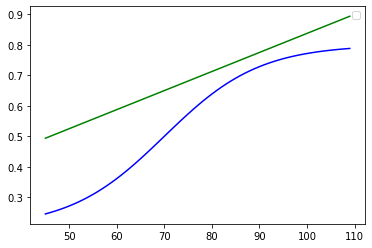

In [68]:
t = np.arange(45,110,1)

#t = np.array([50,50.5,51,52,53])
p1 = logistic(t, 0, 70, 0.2, 0.8, spaceshift=0)
p2 = sum_logistic(t, 0, 70, 0.3, 1, spaceshift=0) 
p3 = linear(t, 0, 70, 0.4, 0.9, spaceshift=0)
p1_source_neg = logistic(t, 0, 70, 0.2, 0.8, 8)
p2_source_neg = sum_logistic(t, 0, 70, 0.3, 1, -8) 
p3_source_neg = linear(t, 0, 70, 0.4, 0.9, -8)
p1_source_pos = logistic(t, 0, 70, 0.2, 0.8, -8)
p2_source_pos = sum_logistic(t, 0, 70, 0.3, 1, 8) 
p3_source_pos = linear(t, 0, 70, 0.4, 0.9, 8)

plt.plot(t,p1,c='b')
plt.plot(t,p3,c='g')

"""
plt.plot(t,p3,c='r')
plt.plot(t,p1_source_pos)
plt.plot(t,p1_source_neg)
plt.plot(t,p3_source_pos)
plt.plot(t,p3_source_neg)
"""
plt.legend()
plt.show()


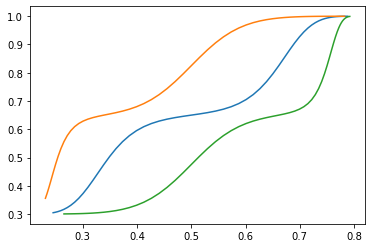

In [4]:
plt.plot(p1,p2)
plt.plot(p1_source_neg,p2_source_neg)
plt.plot(p1_source_pos,p2_source_pos)

In [108]:
# generate the associated trajectories 

visits_per_patients = 5
time_between_visits = 0.5
columns = ['feat1', 'feat2']

noise_std = 0.02

data = []
for sub in feature_parameters.index:
    time_first_visit = np.random.normal(loc=70, scale=15)
    #time_first_visit = 70
    timepoints = [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    id_params = feature_parameters.loc[sub]
    feature_1 = logistic(np.array(timepoints), id_params[0], id_params[1], a=0.2, b=0.8, spaceshift=-id_params[2]/2) + np.random.normal(0, noise_std, visits_per_patients)
    feature_2 = sum_logistic(np.array(timepoints), id_params[0], id_params[1], a=0.3, b=1, spaceshift=id_params[2]/2)+ np.random.normal(0, noise_std, visits_per_patients)
    #feature_2 = linear(np.array(timepoints), id_params[0], id_params[1], a=0.4, b=0.9, spaceshift=id_params[2]/2)+ np.random.normal(0, noise_std, visits_per_patients)

    sub_data = pd.DataFrame([timepoints,feature_1, feature_2]).T
    sub_data.columns = ['TIME', 'feat1', 'feat2']
    sub_data['ID'] = sub
    sub_data = sub_data.set_index(['ID'])
    
    data.append(sub_data)
    
data = pd.concat(data)

In [109]:
# Histogram of reparametrized ages

ages = []
for sub in data.index.unique():
    ip = feature_parameters.loc[sub]
    timepoints = data.loc[sub]['TIME']
    ages += list((np.exp(ip['xi'])*(timepoints - ip['tau']) + 70).values)
    

(array([ 4.,  1.,  0.,  0.,  0.,  4.,  1.,  0.,  0.,  0.,  0.,  1.,  7.,
        11.,  8.,  9., 16., 22., 16., 28., 41., 41., 32., 61., 20., 23.,
        33., 25., 21., 22., 13.,  9.,  1.,  5.,  0.,  1.,  7.,  3.,  6.,
         8.]),
 array([-20.46073285, -16.61129752, -12.7618622 ,  -8.91242687,
         -5.06299154,  -1.21355622,   2.63587911,   6.48531443,
         10.33474976,  14.18418509,  18.03362041,  21.88305574,
         25.73249107,  29.58192639,  33.43136172,  37.28079705,
         41.13023237,  44.9796677 ,  48.82910303,  52.67853835,
         56.52797368,  60.377409  ,  64.22684433,  68.07627966,
         71.92571498,  75.77515031,  79.62458564,  83.47402096,
         87.32345629,  91.17289162,  95.02232694,  98.87176227,
        102.7211976 , 106.57063292, 110.42006825, 114.26950357,
        118.1189389 , 121.96837423, 125.81780955, 129.66724488,
        133.51668021]),
 <BarContainer object of 40 artists>)

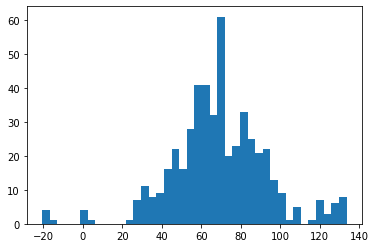

In [110]:
plt.hist(ages, bins=40)

In [111]:
data.describe(percentiles=[.1,.2,.8,.95])

,TIME,feat1,feat2
count,500.000000,500.000000,500.000000
mean,71.172184,0.488478,0.643700
std,15.588227,0.192085,0.262012
min,35.452264,0.161583,0.257160
10%,51.560849,0.238530,0.306081
20%,58.002724,0.288990,0.334179
50%,70.057181,0.466342,0.646782
80%,85.477026,0.702411,0.964174
95%,97.309261,0.784783,1.006217
max,107.135171,0.830033,1.053689


In [112]:
data_path = 'simulated_study/simulated_data_4/'
data.to_csv(data_path + 'simulated_data_4.csv')
feature_parameters.to_csv(data_path + 'true_individual_parameters.csv')

## Save the data 

In [113]:
X = data['TIME'].values
Y = data[['feat1', 'feat2']].values
group = [int(sub) for sub in data.index.values]

In [114]:
np.savetxt(data_path + 'X.csv', X)
np.savetxt(data_path + 'Y.csv', Y, delimiter=',')
np.savetxt(data_path + 'group.csv', group)

In [83]:
data.describe(percentiles=[.1,.2,.3,.5,.7,.8,.9, .95])

,TIME,feat1,feat2
count,800.000000,800.000000,800.000000
mean,71.252696,0.510620,0.655286
std,10.036833,0.189256,0.162464
min,45.421173,0.084783,0.136826
10%,58.891226,0.249743,0.439783
20%,62.573234,0.333949,0.551375
30%,64.859459,0.393284,0.593976
50%,71.445693,0.516825,0.654417
70%,76.979007,0.628455,0.721354
80%,79.929726,0.692023,0.785039


# Simulating with a metric

In [116]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

[pyKeOps]: Warning, cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [126]:
path = 'simulated_study'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_personalize.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [128]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

Patient  129  was estimated with an absurd timeshift tensor(121.4855)
210 good iterations out of 211
192 good iterations out of 241


In [140]:
onset_ages = torch.tensor(feature_parameters['tau'])
log_accelerations = torch.tensor(feature_parameters['xi'])
sources = torch.tensor([[float(source)] for source in feature_parameters['source'].values])

In [183]:
# Timepoints of visits

visits_per_patients = 10
time_between_visits = 0.5

noise_std = 0.02

timepoints_lst = []
timepoints = []

for sub in feature_parameters.index:
    time_first_visit = np.random.normal(loc=70, scale=15)
    timepoints_lst = timepoints_lst + [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    timepoints.append([time_first_visit + i*time_between_visits for i in range(visits_per_patients)])

In [186]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
#onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(np.array(timepoints), log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

Patient  31  was estimated with an absurd timeshift tensor(131.0913)
Patient  40  was estimated with an absurd timeshift tensor(129.4107)
Patient  45  was estimated with an absurd timeshift tensor(161.2729)
210 good iterations out of 211
192 good iterations out of 241


In [187]:
predictions = []
subject_ids = []
times = []

targets = dataset.deformable_objects

number_of_subjects = dataset.number_of_subjects
residuals = []

for i in range(number_of_subjects):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        if sources is not None:
            prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        else:
            prediction = model.spatiotemporal_reference_frame.get_position(t)
        predictions_i.append(prediction.cpu().data.numpy())
        predictions.append(prediction.cpu().data.numpy())
        subject_ids.append(dataset.subject_ids[i])
        times.append(dataset.times[i][j])
    targets_i = targets[i].cpu().data.numpy()


In [150]:
feat_1 = [prediction[0] for prediction in predictions]
feat_2 = [prediction[1] for prediction in predictions]

In [152]:
data_path = 'simulated_study/simulated_data_metric_1/'
feature_parameters.to_csv(data_path + 'true_individual_parameters.csv')

## Save the data 

In [205]:
X = np.array(timepoints_lst)
Y = predictions
group = []
for i in range(len(timepoints)):
    group = group + [i for j in range(10)]

In [206]:
np.savetxt(data_path + 'X.csv', X)
np.savetxt(data_path + 'Y.csv', Y, delimiter=',')
np.savetxt(data_path + 'group.csv', group)

In [190]:
data.index.values

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20,
       20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27,
       27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30,
       30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
       34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37,
       37, 37, 37, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40,
       40, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 44,
       44, 44, 44, 44, 45